# DAE Mini Assignment
## Analysing the relationship between the production of coal and the amount of electricity generated in South Africa

Many factors influence the amount of electricity that can be generated in a country. Some of these include the number of available generators, the price of resources, such as coal and oil,** and the amount of coal and oil produced. The purpose of this notebook is to answer the question: "Does coal production significantly effect the amount of power produced in South Africa?" To do this, the data will go through ananlysis and exploration to determine if there is a relationship and, if so, what the relationship is. A logistic regression function will then be implemented to attempt to fit the model and predict future data.

### The Data
The first dataset that will be used in this notebook contains information on the production and sales of the mining industry. This information was collected (up to, and including, December 2019) by surveying the Department of Mineral Resources and Energy (DMRE) and was published on 13 February 2020. The dataset can be found [here](http://www.statssa.gov.za/?page_id=1854&PPN=P2041&SCH=7550) (downloaded on 21 February 2020). In the 44x214 table, the physical volume of mining production (actual indexes and seasonally adjusted indexes), as well as mineral sales for all the resources South Africa mines, can be found. This helps in answering the question as we can use the actual physical volume of mining production index for coal.

The second dataset contains data on electricity generated and available for distribution. The data was collected by statsSA (up to, and including, December 2019) through surveying establishments in the electricity industry. This dataset can be found [here](http://www.statssa.gov.za/?page_id=1854&PPN=P4141&SCH=7546) (downloaded on 21 February 2020). The 24x251 table contains information ranging from the total available electricity generated in South Africa to the amount of electricity distributed to each province. To answer the question at hand, we will be looking at the total generated in all of South Africa.

The quality of the data is high as it is valid, complete, consistent, uniform and assumed to be accuarate as it has been take from a governmental site.

In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
from pandas.plotting import register_matplotlib_converters
from scipy import signal
import seaborn as sns
pd.set_option('display.notebook_repr_html', True)

### Load Data

In [13]:
#Data for Electricity
power_series = pd.read_excel('Electricity from 2000.xlsx' )
display(power_series.head())

,H01,H02,H03,H04,H05,H13,H14,H16,H17,H18,...,MO032019,MO042019,MO052019,MO062019,MO072019,MO082019,MO092019,MO102019,MO112019,MO122019
0,P4141,Electricity generated and available for distri...,ELEKTS10,Total - All producers,Electricity available for distribution in Sout...,NaN,NaN,Seasonally adjusted,Gigawatt-hours,NaN,...,18751.0,19309.0,19229.0,19073.0,18961.0,18463.0,19066.0,18961.0,18664.0,18419.0
1,P4141,Electricity generated and available for distri...,ELEKIN11,Physical volume of electricity production,NaN,NaN,NaN,NaN,Index,Base: 2015=100,...,100.4,99.4,105.9,105.2,108.1,103.0,99.6,103.4,99.0,94.1
2,P4141,Electricity generated and available for distri...,ELEKIS11,Physical volume of electricity production,NaN,NaN,NaN,Seasonally adjusted,Index,Base: 2015=100,...,99.7,102.9,102.2,102.6,101.2,99.2,101.5,100.4,99.3,97.7
3,P4141,Electricity generated and available for distri...,ELEKTR11,Total - All producers,Electricity produced,NaN,NaN,NaN,Gigawatt-hours,NaN,...,20943.0,20733.0,22090.0,21947.0,22552.0,21500.0,20781.0,21571.0,20653.0,19640.0
4,P4141,Electricity generated and available for distri...,ELEKTR13,Total - All producers,Purchased outside South Africa (import),NaN,NaN,NaN,Gigawatt-hours,NaN,...,707.0,689.0,888.0,692.0,825.0,766.0,817.0,900.0,903.0,953.0


In [14]:
#Data for Mineral Production
coal_series = pd.read_excel('Coal from 2003.xlsx')
display(coal_series.head())

,H01,H02,H03,H04,H05,H06,H16,H17,H18,H25,...,MO032019,MO042019,MO052019,MO062019,MO072019,MO082019,MO092019,MO102019,MO112019,MO122019
0,P2041,Mining: Production and sales,FMP20000,Physical volume of mining production,"Total, gold included",NaN,Actual indices,Index,2015=100,Monthly,...,97.0,90.6,103.1,107.5,98.5,102.5,101.9,103.7,101.8,94.2
1,P2041,Mining: Production and sales,FMP20001,Physical volume of mining production,"Total, gold excluded",NaN,Actual indices,Index,2015=100,Monthly,...,103.3,95.9,110.2,113.6,103.1,106.6,105.8,107.8,105.8,97.6
2,P2041,Mining: Production and sales,FMP21000,Physical volume of mining production,Coal,NaN,Actual indices,Index,2015=100,Monthly,...,104.8,95.5,112.0,105.7,112.2,109.1,101.3,107.3,102.5,77.6
3,P2041,Mining: Production and sales,FMP23010,Physical volume of mining production,Iron ore,NaN,Actual indices,Index,2015=100,Monthly,...,93.8,90.7,105.6,122.0,98.5,95.1,109.9,97.7,107.5,117.4
4,P2041,Mining: Production and sales,FMP23020,Physical volume of mining production,Chromium,NaN,Actual indices,Index,2015=100,Monthly,...,110.9,112.4,119.0,120.6,116.6,117.8,114.0,124.2,121.7,105.3


It is clear to see that the data is very untidy and almost unreadable in its current state. To fix this, both tables are transposed so that the dates can be the rows, and then the data frame is spliced so that they only have the information we require. In this case, we need the total electricity generated from the power table and the actual physical volume of mining production from the coal table. The labels for the months are renamed for readability and then converted to a datetime type and the numerical data is converted to float64.

In [15]:
power_df = pd.DataFrame(power_series.T[11:][0].rename('Total Electricity Generated (GWh)'))
power_df.index.name = 'Month'
power_df.index = power_df.index.map(lambda s: s[4:] + '-' + s[2:4] + '-01')

power_df.index = pd.to_datetime(power_df.index)
power_df['Total Electricity Generated (GWh)'] = power_df['Total Electricity Generated (GWh)'].astype(float)

display(power_df.head())
display(power_df.info())

,Total Electricity Generated (GWh)
Month,
2000-01-01,15916.0
2000-02-01,15981.0
2000-03-01,16106.0
2000-04-01,16347.0
2000-05-01,16329.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2000-01-01 to 2019-12-01
Data columns (total 1 columns):
Total Electricity Generated (GWh)    240 non-null float64
dtypes: float64(1)
memory usage: 3.8 KB


None

In [16]:
coal_df = pd.DataFrame(coal_series.T[10:][2].rename('Actual Coal Index'))
coal_df.index.name = 'Month'
coal_df.index = coal_df.index.map(lambda s: s[4:] + '-' + s[2:4] + '-01')
coal_df.index = pd.to_datetime(coal_df.index)
coal_df['Actual Coal Index'] = coal_df['Actual Coal Index'].astype(float)
display(coal_df.head())
display(coal_df.info())

,Actual Coal Index
Month,
2003-01-01,86.5
2003-02-01,82.9
2003-03-01,87.9
2003-04-01,89.7
2003-05-01,101.8


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2003-01-01 to 2019-12-01
Data columns (total 1 columns):
Actual Coal Index    204 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


None

The data is now easier to read compared to the raw data and can now be analysed.

In [17]:
#Making both data sets equal size. 
#Coal starting 1 month before electricity and electricty ending 1 month after
if np.shape(power_df) != np.shape(coal_df):
    power_df = power_df[37:]
    coal_df = coal_df[:-1]
coal_temp = coal_df.copy()
coal_temp.index = power_df.index


For this notebook, we will be looking at the previous month's coal production and comparing it to the current month's electricity generated.

### Exploratory Analysis


In [18]:
#Calculating the correlation coefficient
correlcoeff = np.corrcoef(power_df['Total Electricity Generated (GWh)'],coal_df['Actual Coal Index'])[0,1]
print('The correlation coefficient of the data is ', correlcoeff )

The correlation coefficient of the data is  0.23235245004885707


The correlation coefficient shows that the production of coal and the power generated in South Africa have a weak positive relationship. Even though the relationship is weak, it still shows that there is a correlation and that there is cause for comparing the datas and answering the question.

<IPython.core.display.Javascript object>


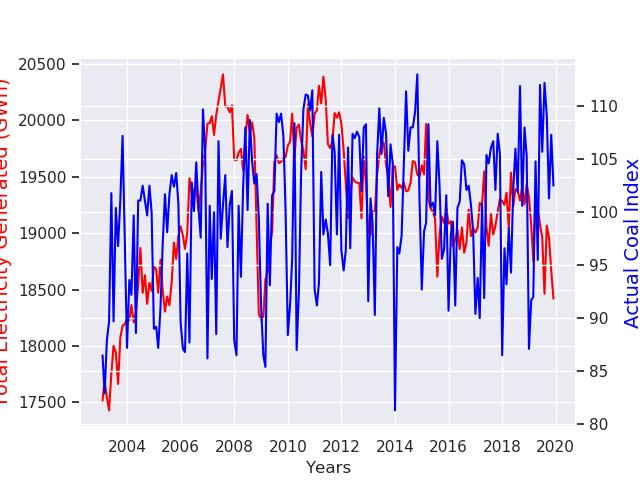

In [19]:
#Plotting the two data sets on the same set of axes
%matplotlib notebook
register_matplotlib_converters()
fig,ax = plt.subplots()
ax2 = ax.twinx()

locator = AutoDateLocator()
formatter = DateFormatter('%Y')

ax.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_locator(locator)


ax.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_formatter(formatter)

ax.plot(power_df.index, power_df['Total Electricity Generated (GWh)'], color = 'red')
ax.set_ylabel('Total Electricity Generated (GWh)',fontsize = 14, color = 'red')
ax.set_xlabel('Years')

ax2.plot(coal_temp.index,coal_temp['Actual Coal Index'], color = 'blue')
ax2.set_ylabel('Actual Coal Index',fontsize = 14, color = 'blue')

sns.set()
ax.xaxis_date()
ax2.xaxis_date()
plt.show()

Plotting the two data sets in figure 1, visually shows us that they are correlated since both plots are quite similar. The graph also shows us that both data sets experience regular fluctuations every calendar year. This is known as seasonality and may be the cause for the low correlation coefficient of the two data sets. Using the cross-correlation graph and the autocorrelation graph will help in identifying the lags in the data and to detect the seasonality. The data sets will be adjusted for the seasonality and then re-analysed and explored.